In [ ]:
from utils.file_utils import merge_csv, read_csv
from utils.calc_distance import add_nearest_mrt
from utils.geocode import geocode
from preprocessing.clean import clean_data
from preprocessing.encode import encode_data
from models.validate import prepare_split
from models.graph import plot_prediction, plot_residuals
from models.knn import get_knn, test_k_values, test_knn
from models.linear_regression import test_alpha_value,test_linear,test_lasso,test_ridge
from models.regression_tree import test_tree_depth, test_rt
from models.random_forest import test_rf
from models.comparison import run_model_comparison, plot_model_comparison,summarize_best_models

In [2]:
# Prepare data set
data = read_csv('output/encoded_data.csv') 
train_X, test_X, train_y, test_y = prepare_split(data)

# Model Optimization



## Linear Regression


First, we tried multiple values of alpha to determine the most optimal value of alpha for ridge or lasso regularization for this data set.

In [6]:
import warnings
warnings.simplefilter('ignore')
test_alpha_value(train_X, train_y)

Best alpha for Lasso: 0.5
Best alpha for Ridge: 0.5


Using this optimal alpha value of 0.5, we tested each linear regularization method against each other, testing against the metrics of MAE and Cross Validation R2 scoring.

In [9]:
y_pred_linear = test_linear(train_X, test_X, train_y, test_y)

RMSE: 74034.57930
MAE: 58589.04465
R2: 0.80315
Cross-validation R2 scores: [0.80782956 0.80570993 0.808826   0.805846   0.80610999]
Mean CV R2: 0.80686


In [4]:
y_pred_ridge = test_ridge(train_X, test_X, train_y, test_y, alpha = 0.5)

Ridge RMSE: 74034.22982
Ridge MAE: 58589.47442
Ridge R2: 0.80315


In [7]:
y_pred_lasso = test_lasso(train_X, test_X, train_y, test_y, alpha = 0.5)

Lasso RMSE: 74036.04581
Lasso MAE: 58590.07212
Lasso R2: 0.80314


We concluded that linear regression is slightly more optimal than the regularization methods. This is supported by our initial EDA which showed that all features contributed equally to the prediction and overfitting is not necessarily an issue for this data. Therefore, we chose to utilize the simpler an dmore interpretable model of base linear regression.

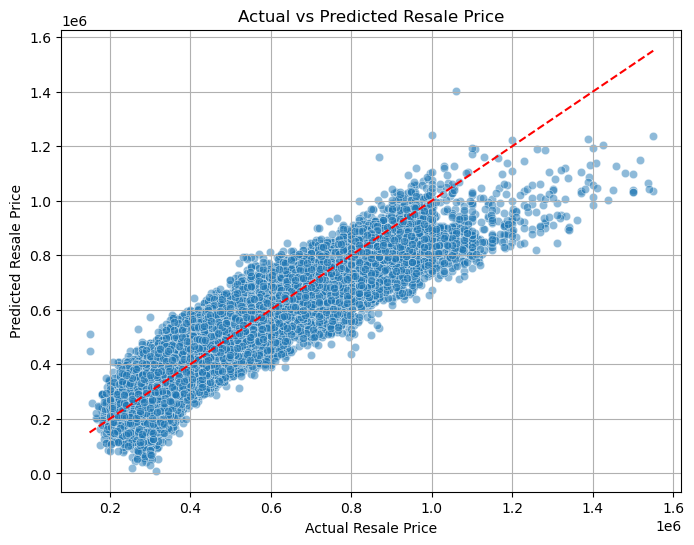

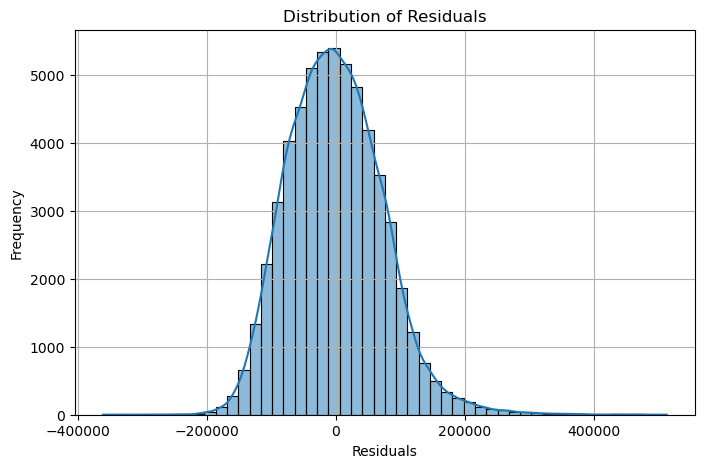

In [10]:
plot_prediction(test_y, y_pred_linear)
plot_residuals(test_y, y_pred_linear)

From the plots, we conclude that:

**Prediction Plot**
- Relatively tight clustering around the diagonal line
- Strong linear trend
- Big spike in variance for the higher-priced resale flats
    - Possibility of non-linear relationship between features and resale price for higher values, or outliers

**Residuals**
- Centered at zero -> No consistent bias
- Symmetrical and bell-shaped -> Normally distributed
- Lack of skew -> Extreme errors are rare

## K Nearest Neighbours

First, we attempt to find the most optimal k value for the nearest neighbour algorithim by plotting Cross Validation Mean R2 against k.

1 nearest neighbour: R^2 value: 0.9073479954469199
21 nearest neighbour: R^2 value: 0.9263388599943262
41 nearest neighbour: R^2 value: 0.9132356462240839
61 nearest neighbour: R^2 value: 0.9035112978188403
81 nearest neighbour: R^2 value: 0.8960652692600162
101 nearest neighbour: R^2 value: 0.8898348637959597
121 nearest neighbour: R^2 value: 0.8843895392056949
141 nearest neighbour: R^2 value: 0.8795873078224785
161 nearest neighbour: R^2 value: 0.8752700667543536
181 nearest neighbour: R^2 value: 0.8713375940061301
201 nearest neighbour: R^2 value: 0.8677484452839475
221 nearest neighbour: R^2 value: 0.8643901380522576
241 nearest neighbour: R^2 value: 0.8612715607796659
261 nearest neighbour: R^2 value: 0.8583591279480791
281 nearest neighbour: R^2 value: 0.8556448330674401
301 nearest neighbour: R^2 value: 0.853088270186736
321 nearest neighbour: R^2 value: 0.8506780910702924
341 nearest neighbour: R^2 value: 0.8484090712903157
361 nearest neighbour: R^2 value: 0.8462457785210941


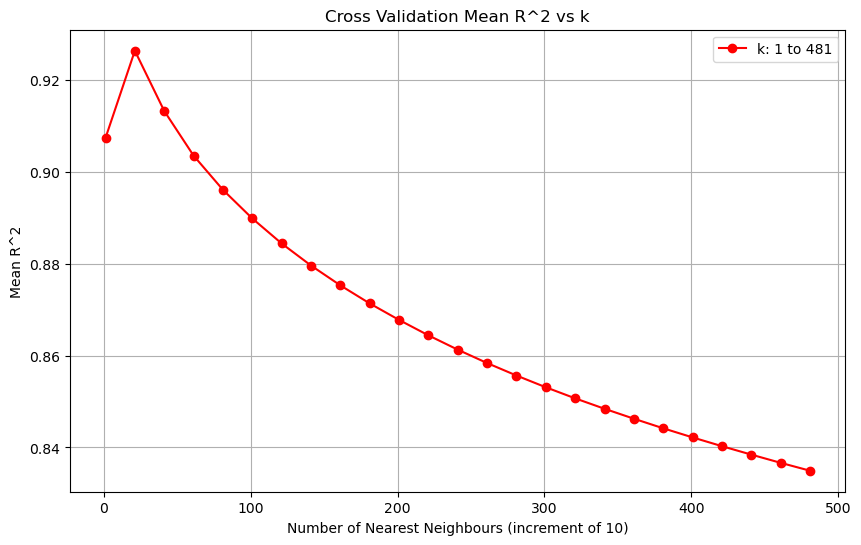

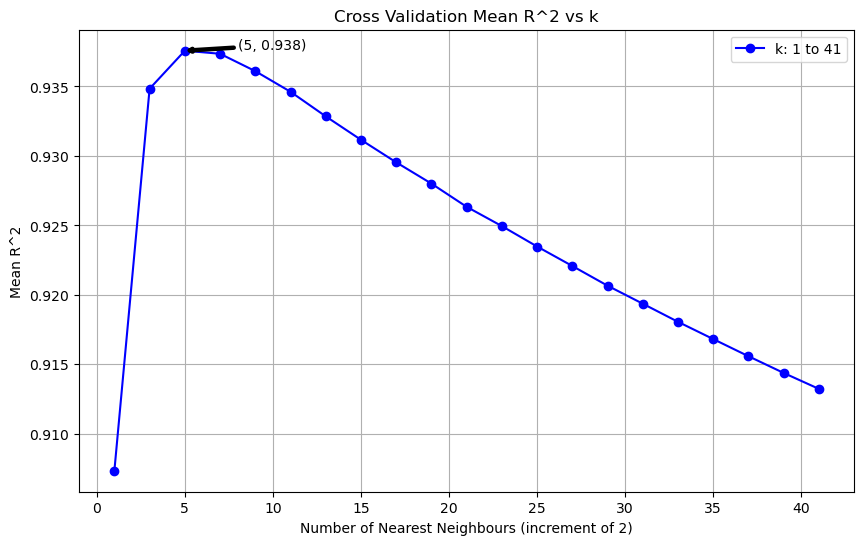

Best k value is 5 with R^2 score of 0.938


5

In [4]:
test_k_values(train_X, train_y)

Based on the earlier analysis, using 5-fold cross validation, R^2 value of the kNN models is maximised with k = 5 nearest neighbours with a mean R^2 value of 0.976

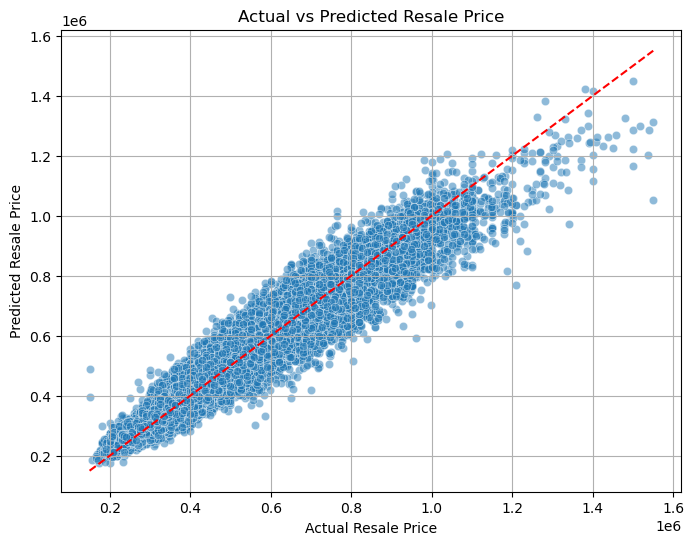

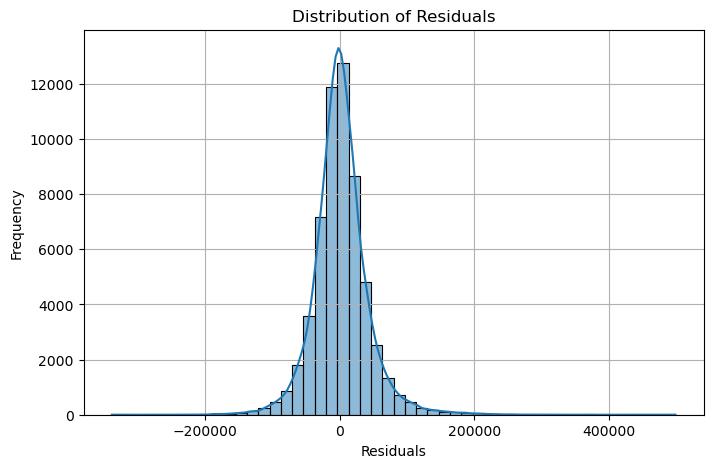

In [3]:
y_pred_knn = test_knn(train_X, test_X, train_y, n=5)
plot_prediction(test_y, y_pred_knn)
plot_residuals(test_y, y_pred_knn)

## Regression Tree


Depth 3: Mean R² = 0.5074258786788123
Depth 4: Mean R² = 0.6361387855828695
Depth 5: Mean R² = 0.7130078098860599
Depth 6: Mean R² = 0.7600644614747868
Depth 7: Mean R² = 0.7980646652202669
Depth 8: Mean R² = 0.8291074031553342
Depth 9: Mean R² = 0.8587692112653901
Depth 10: Mean R² = 0.879567798978315
Depth 11: Mean R² = 0.8977175840398637
Depth 12: Mean R² = 0.9116361065511235
Depth 13: Mean R² = 0.9225723007023194
Depth 14: Mean R² = 0.9313823685638276
Depth 15: Mean R² = 0.9371793491182366
Depth 16: Mean R² = 0.9412733045239371
Depth 17: Mean R² = 0.9439606994697037
Depth 18: Mean R² = 0.9458243515519378
Depth 19: Mean R² = 0.9465574921923643
Depth 20: Mean R² = 0.9466203565163418


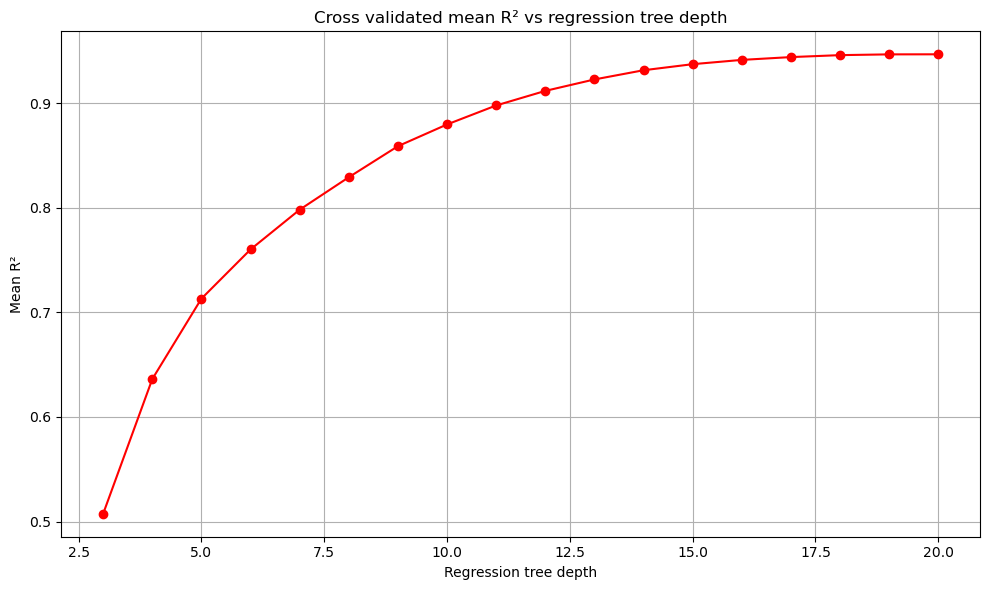

In [15]:
test_tree_depth(train_X, train_y)

We decided to choose a tree depth of 16 through 5-fold validation as not only does the mean R² values begin to plaeaeu, 
with R² values improvements becoming less than 1% beyond 16. Beyond this, a larger depth means a more complex model, and thus
the chance that the model might overfit to the training data increases even further.

In [4]:
y_pred_rt= test_rt(train_X, test_X, train_y, test_y)

Decision Tree accuracy for training set: 0.965199
Decision Tree accuracy for test set: 0.942986
Mean absolute error: ±$27874.19946572858


## Random Forest

In [5]:
y_pred_rf = test_rf(train_X, test_X, train_y, test_y)

Mean Squared Error: 794524989.139691
R^2 Score: 0.9714650756927724


# Model Comparison

In [ ]:
feature_configs = [
    # Configuration 1: Baseline (No features)
    {
        'name': 'Baseline',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False
    },
    
    # Configuration 2: Handle Outliers only
    {
        'name': 'Outliers Only',
        'encoding_method': 'one_hot',
        'handle_outliers': True,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False
    },
    
    # Configuration 3: Cyclic Month only
    {
        'name': 'Cyclic Month',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': True,
        'normal_year': False,
        'normal_price': False
    },
    
    # Configuration 4: Normalized Year only
    {
        'name': 'Normalized Year',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': True,
        'normal_price': False
    },
    
    # Configuration 5: Moving Window only
    {
        'name': 'Moving Window',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': True,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False
    },
    
    # Configuration 6: Target Encoding (instead of One-Hot)
    {
        'name': 'Target Encoding',
        'encoding_method': 'target',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False
    },
    
    # Configuration 7: Temporal Features
    {
        'name': 'Temporal Features',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': True,
        'cyclic_month': True,
        'normal_year': True,
        'normal_price': False
    },
    
    # Configuration 8: Everything Enabled
    {
        'name': 'All Features',
        'encoding_method': 'one_hot',
        'handle_outliers': True,
        'moving_window': True,
        'cyclic_month': True,
        'normal_year': True,
        'normal_price': True
    }
]

In [ ]:

# Run the model comparison
print("Starting model comparison across different feature configurations...")
results = run_model_comparison(feature_configs)

# Plot R² comparison
print("\nPlotting R² comparison...")
plot_model_comparison(results, metric='r2')

# Plot RMSE comparison
print("\nPlotting RMSE comparison...")
plot_model_comparison(results, metric='rmse')

# Plot MAE comparison
print("\nPlotting MAE comparison...")
plot_model_comparison(results, metric='mae')

# Summarize the best models
best_models = summarize_best_models(results)
print("\nBest Models by Configuration (sorted by R²):")
print(best_models)

# Find overall best configuration
best_config = best_models.iloc[0]
print(f"\nOverall best performance: {best_config['Configuration']} with {best_config['Best Model']}")
print(f"R²: {best_config['R²']:.4f}, RMSE: {best_config['RMSE']:.2f}, MAE: {best_config['MAE']:.2f}")